In [1]:
import os
import numpy as np
import pandas as pd
import sys
import re
from datetime import datetime

In [2]:
import ipython_exit
import helper_v31102020 as utils

In [3]:
import locale

In [4]:
#Выставим опции pandas для удобства просмотра
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 200)

In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## 1. Загрузка данных

In [6]:
PATH_to_file = './data/'

In [7]:
lst_files = os.listdir(PATH_to_file)

In [8]:
data_all = []

for fl in lst_files:
    data = pd.read_csv(PATH_to_file + fl)
    data_all.append(data)

df = pd.concat(data_all)

In [9]:
df.sample(10)

,id,page,url,district,live_rooms,title,price,address,text_preview,owner,stats_city,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,pars_date,flat.building,flat.floor,live.square,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,options_text,text
3552,665814633,179,https://krisha.kz/a/show/665814633,almaty-bostandykskij,2.0,"2-комнатная квартира, 53 м², 5/12 этаж",34500000,"Бостандыкский р-н, Сатпаева","жил. комплекс Симфония, монолитный дом, 2017 г.п., состояние: евроремонт, потолки 2.7м., санузел раздельный, телефон: отдельный, интернет проводной, полностью меблирована, СРОЧНАЯ ПРОДАЖА!",Специалист,Алматы,15 мар.,0,0,0,0,0,0,21-03-2021 07:44:31,"монолитный, 2017 г.п.",5 из 12,53 м²,евроремонт,раздельный,балкон,NaN,Симфония,металлическая,проводной,полностью меблирована,NaN,2.7 м,"домофон, видеодомофон",NaN,отдельный,паркинг,нет,"Пластиковые окна, неугловая, улучшенная, кухня-студия, встроенная кухня, счётчики, тихий двор, кондиционер.",СРОЧНАЯ ПРОДАЖА!
1072,665572610,54,https://krisha.kz/a/show/665572610,almaty-aujezovskij,2.0,"2-комнатная квартира, 72 м², 2/10 этаж",33000000,"Ауэзовский р-н, Жандосова — Саина","монолитный дом, 2006 г.п., состояние: хорошее, санузел раздельный, Внимание, СРОЧНО! Двухкомнатная квартира улучшенной планировки в одном из самых востребованных районов города! Квартира в исключи...",Специалист,Алматы,4 мар.,0,0,0,0,0,0,07-03-2021 03:20:16,"монолитный, 2006 г.п.",2 из 10,"72 м², кухня — 16.5 м²",хорошее,раздельный,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,"Внимание, СРОЧНО! Двухкомнатная квартира улучшенной планировки в одном из самых востребованных районов города! Квартира в исключительном состоянии! Не требует капитальных вложений! Развитая инфрас..."
84,665183651,5,https://krisha.kz/a/show/665183651,almaty-bostandykskij,1.0,"1-комнатная квартира, 40 м², 3/4 этаж",19500000,"Бостандыкский р-н, Жандарбекова 191А — Жандосова","кирпичный дом, 1962 г.п., состояние: хорошее, жил. площадь 23 кв.м., кухня 6 кв.м., потолки 2.5м., санузел совмещенный, полностью меблирована, Продается квартира-полуторка в очень востребованном р...",Специалист,Алматы,6 мар.,1,0,0,0,0,0,07-03-2021 04:40:50,"кирпичный, 1962 г.п.",3 из 4,"40 м², жилая — 23 м², кухня — 6 м²",хорошее,совмещенный,балкон,да,NaN,металлическая,NaN,полностью меблирована,линолеум,2.5 м,"домофон, видеонаблюдение",NaN,NaN,рядом охраняемая стоянка,нет,"Пластиковые окна, встроенная кухня, счётчики, тихий двор, кондиционер.",Продается квартира-полуторка в очень востребованном районе города. Все объекты развитой инфраструктуры в шаговой доступности. Дом расположен во дворах - вдали от шума проезжей части. Во дворе всег...
48,665602173,3,https://krisha.kz/a/show/665602173,almaty-aujezovskij,4.0,"4-комнатная квартира, 77 м², 3/5 этаж",32500000,"Ауэзовский р-н, мкр Мамыр, Яссауи — Шаляпина","кирпичный дом, 1990 г.п., состояние: хорошее, жил. площадь 52 кв.м., кухня 11 кв.м., потолки 2.7м., санузел раздельный, частично меблирована, СРОЧНО! Продается 4-х комнатная квартира улучшенной пл...",Проверенный специалист,Алматы,6 мар.,0,0,0,0,0,0,07-03-2021 04:33:55,"кирпичный, 1990 г.п.",3 из 5,"77 м², жилая — 52 м², кухня — 11 м²",хорошее,раздельный,балкон и лоджия,NaN,NaN,NaN,NaN,частично меблирована,линолеум,2.7 м,NaN,NaN,NaN,рядом охраняемая стоянка,нет,NaN,СРОЧНО! \n \n Продается 4-х комнатная квартира улучшенной планировки в кирпично-ригельном сейсмоустойчивом доме. \n \n Квартира на самом ходовом ТРЕТЬЕМ этаже. НЕ УГЛОВАЯ! \n \n В стоимость кварти...
749,665885670,38,https://krisha.kz/a/show/665885670,almaty-almalinskij,1.0,"1-комнатная квартира, 39 м², 3/5 этаж",19500000,"Алмалинский р-н, Нурмакова — Казыбек Би","кирпичный дом, 1996 г.п., состояние: среднее, жил. площадь 18 кв.м., кухня 8.7 кв.м., санузел совмещенный, телефон: отдельный, интернет ADSL, частично меблирована, Развитая инфраструк

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147029 entries, 0 to 4
Data columns (total 39 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               147029 non-null  int64  
 1   page             147029 non-null  int64  
 2   url              147029 non-null  object 
 3   district         147029 non-null  object 
 4   live_rooms       147029 non-null  float64
 5   title            147029 non-null  object 
 6   price            147029 non-null  int64  
 7   address          147029 non-null  object 
 8   text_preview     147029 non-null  object 
 9   owner            147029 non-null  object 
 10  stats_city       147029 non-null  object 
 11  ad_date          147029 non-null  object 
 12  paid_hot         147029 non-null  int64  
 13  paid_up          147029 non-null  int64  
 14  paid_fast        147029 non-null  int64  
 15  paid_urgent      147029 non-null  int64  
 16  paid_turbo       147029 non-null  int64  
 

### Устранение дублей

In [11]:
df.id.value_counts(ascending=True)[:3]

665593861    1
665652204    1
665916399    1
Name: id, dtype: int64

In [12]:
valuable_columns = list(df.columns)
valuable_columns.remove('id')
valuable_columns.remove('page')
valuable_columns.remove('url')
valuable_columns.remove('ad_date')
valuable_columns.remove('pars_date')
print(valuable_columns)

['district', 'live_rooms', 'title', 'price', 'address', 'text_preview', 'owner', 'stats_city', 'paid_hot', 'paid_up', 'paid_fast', 'paid_urgent', 'paid_turbo', 'highlighted', 'flat.building', 'flat.floor', 'live.square', 'flat.renovation', 'flat.toilet', 'flat.balcony', 'flat.balcony_g', 'map.complex', 'flat.door', 'inet.type', 'live.furniture', 'flat.flooring', 'ceiling', 'flat.security', 'has_change', 'flat.phone', 'flat.parking', 'flat.priv_dorm', 'options_text', 'text']


In [13]:
df.drop_duplicates(subset=valuable_columns, inplace=True, keep='last')

In [14]:
len(df)

92528

### Столько объявлений останется, если оставить только "значимые столбцы" и удалить дубли.

## 2. Обработка признаков

### Удаляем неинформативные признаки

In [15]:
df.drop(['id', 'page', 'url', 'pars_date', 'stats_city'], axis=1, inplace=True)

In [16]:
#df.reset_index(drop=True)

### Для простоты пока удалим текстовые признаки (потом, возможно, попробуем NLP). Также, будут полезны такие сведения, как "Угловая-Неугловая" и другие просто по ключевым словам.

In [17]:
df.drop(['text_preview', 'options_text', 'text'], axis=1, inplace=True)

### Также пока удалим текстовый признак address. Потом попробуем его использовать для повышения точности модели

In [18]:
df.drop(['address'], axis=1, inplace=True)

### "Закодируем" первую группу категориальных признаков без пропусков (Label Encoding)

In [19]:
cat_f_1 = ['district', 'owner']

In [20]:
for col in cat_f_1:
    print(col, df[col].nunique(), '\n', df[col].value_counts(), '\n')

district 8 
 almaty-bostandykskij    28676
almaty-aujezovskij      18990
almaty-almalinskij      18501
almaty-medeuskij        10231
almaty-alatauskij        5003
almaty-nauryzbajskiy     3983
almaty-zhetysuskij       3979
almaty-turksibskij       3165
Name: district, dtype: int64 

owner 7 
 Специалист                54629
Хозяин недвижимости       22119
Проверенный специалист     9853
Проверенная компания       2977
Компания                   2877
Специалист оштрафован        49
На проверке                  24
Name: owner, dtype: int64 



In [21]:
# Кодируем категориальные признаки
for col in cat_f_1:
    df[col] = df[col].astype('category').cat.codes

In [22]:
#Проверяем
for col in cat_f_1:
    print(col, df[col].nunique(), '\n', df[col].value_counts(), '\n')

district 8 
 3    28676
2    18990
1    18501
4    10231
0     5003
5     3983
7     3979
6     3165
Name: district, dtype: int64 

owner 7 
 4    54629
6    22119
3     9853
2     2977
0     2877
5       49
1       24
Name: owner, dtype: int64 



### Теперь из признаков live_rooms, title, flat.floor и live.square нужно получить количество комнат, площадь, этаж, на котором находится квартира и количество этажей в доме. Также, будут полезны новые признаки, как Первый этаж, Последний этаж, Отношение площади к количеству комнат.

Определяем функции

In [23]:
def extract_live_rooms(str_title):
    return int(str_title.split(', ', 2)[0].split('-', 1)[0])

In [24]:
def extract_square(str_title):
    return float(str_title.split(', ', 2)[1].split(' м²', 1)[0])

In [25]:
def extract_flat_floor(str_title):
    temp_arr = str_title.split(', ', 2)
    if len(temp_arr) >=3:
        temp_str = temp_arr[2]
        if '/' in temp_str:
            return int(temp_str.split('/', 1)[0])
        else:
            return int(temp_str.split(' этаж', 1)[0])
    else:
        #print(str_title)
        return 0

In [26]:
def extract_building_floor(str_title):
    temp_arr = str_title.split(', ', 2)
    if len(temp_arr) >=3:
        temp_str = temp_arr[2]
        if '/' in temp_str:
            return int(temp_str.split('/', 1)[1].split(' этаж', 1)[0])
        else:
            return 0
    else:
        #print(str_title)
        return 0

In [27]:
def extract_flat_floor1(str_flat_floor):
    str_flat_floor_temp = str(str_flat_floor)
    if str_flat_floor_temp != 'nan':
        if ' из ' in str_flat_floor_temp:
            return int(str_flat_floor_temp.split(' из ', 1)[0])
        else:
            return int(str_flat_floor_temp)
    else:
        return 0

In [28]:
def extract_building_floor1(str_flat_floor):
    str_flat_floor_temp = str(str_flat_floor)
    if str_flat_floor_temp != 'nan':
        if ' из ' in str_flat_floor_temp:
            return int(str_flat_floor_temp.split(' из ', 1)[1])
        else:
            return 0
    else:
        return 0

Генерируем и проверяем признаки

**live_rooms**

In [30]:
df['live_rooms1'] = df.title.apply(lambda x: extract_live_rooms(x))

In [31]:
df['live_rooms1'].value_counts(dropna=False)

2     33066
3     31092
1     20476
4      6515
5       949
6       227
7       110
8        45
9        25
12       11
10        8
32        1
20        1
14        1
11        1
Name: live_rooms1, dtype: int64

In [32]:
df_temp = df[df.live_rooms <= 4]
df_temp[(df_temp.live_rooms - df_temp.live_rooms1) != 0]

,district,live_rooms,title,price,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.floor,live.square,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,live_rooms1


Эта проверка показывает, что мы правильно извлекли количество комнат из заголовка объявления

In [33]:
df.live_rooms = df.live_rooms1
df.drop(['live_rooms1'], axis=1, inplace=True)

Количество: 92528, Среднее: 2.310, Стандартное отклонение: 0.984.
Минимум: 1, 25-й перцентиль: 2.0, Медиана: 2.0, 75-й перцентиль: 3.0, Максимум: 32, IQR: 1.0.
Количество пропусков в столбце:  0
Границы выбросов: [0.5, 4.5]. Количество выбросов:  1379


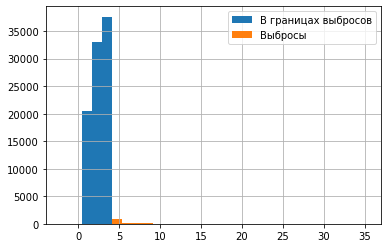

In [35]:
utils.analyse_numeric(df, 'live_rooms')

**square_meters**

In [36]:
df['square_meters'] = df.title.apply(lambda x: extract_square(x))

Количество: 92528, Среднее: 68.616, Стандартное отклонение: 41.051.
Минимум: 8.97, 25-й перцентиль: 44.0, Медиана: 60.0, 75-й перцентиль: 78.0, Максимум: 1480.0, IQR: 34.0.
Количество пропусков в столбце:  0
Границы выбросов: [-7.0, 129.0]. Количество выбросов:  6032


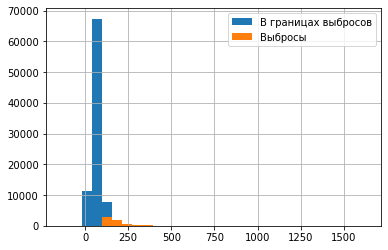

In [37]:
utils.analyse_numeric(df, 'square_meters')

**flat_floor**

In [38]:
df['flat_floor'] = df.title.apply(lambda x: extract_flat_floor(x))

In [39]:
df['flat_floor'].value_counts(dropna=False)

2     13979
4     13482
3     13212
5     11824
1     11585
8      4612
6      4457
9      4373
7      4129
10     2266
12     1579
0      1510
11     1502
14      801
13      776
16      757
15      734
17      249
19      193
18      185
20      138
21      116
22       26
24       13
23       12
26        7
25        4
27        2
77        1
37        1
70        1
99        1
58        1
Name: flat_floor, dtype: int64

In [40]:
df['flat_floor1'] = df['flat.floor'].apply(lambda x: extract_flat_floor1(x))

In [41]:
df['flat_floor1'].value_counts(dropna=False)

2     13996
4     13488
3     13232
5     11860
1     11586
8      4612
6      4468
9      4412
7      4138
10     2304
12     1710
11     1505
0       920
14      837
13      809
16      789
15      744
17      316
18      231
19      199
20      142
21      138
22       27
25       24
23       14
24       13
26        7
27        2
77        1
37        1
70        1
99        1
58        1
Name: flat_floor1, dtype: int64

**building_floor**

In [42]:
df['building_floor'] = df.title.apply(lambda x: extract_building_floor(x))

In [43]:
df['building_floor'].value_counts(dropna=False)

5      26547
9      13911
4      13230
12      6786
10      4781
16      3685
3       2745
13      2639
6       2431
0       1966
14      1532
2       1495
15      1492
8       1417
7       1411
18      1355
17      1281
21      1038
20       743
11       690
25       410
22       379
19       253
1        146
30        44
23        44
33        43
31         9
32         6
29         6
24         3
100        1
54         1
49         1
38         1
121        1
98         1
28         1
76         1
26         1
252        1
Name: building_floor, dtype: int64

In [44]:
df['building_floor1'] = df['flat.floor'].apply(lambda x: extract_building_floor1(x))

In [45]:
df['building_floor1'].value_counts(dropna=False)

5      26547
9      13911
4      13230
12      6786
10      4781
16      3685
3       2745
13      2639
6       2431
0       1966
14      1532
2       1495
15      1492
8       1417
7       1411
18      1355
17      1281
21      1038
20       743
11       690
25       410
22       379
19       253
1        146
30        44
23        44
33        43
31         9
32         6
29         6
24         3
100        1
54         1
49         1
38         1
121        1
98         1
28         1
76         1
26         1
252        1
Name: building_floor1, dtype: int64

ToDo: Теперь сделать по одной колонке и обработать live.square

In [46]:
df.sample(1)

,district,live_rooms,title,price,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.floor,live.square,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm,square_meters,flat_floor,flat_floor1,building_floor,building_floor1
2299,2,2,"2-комнатная квартира, 45 м², 2/4 этаж",13500000,0,1 мар.,1,0,0,0,0,0,"кирпичный, 1968 г.п.",2 из 4,"45 м², жилая — 22 м², кухня — 14 м²",хорошее,раздельный,балкон,да,NaN,металлическая,ADSL,полностью меблирована,NaN,2.8 м,NaN,NaN,отдельный,NaN,да,45.0,2,2,4,4


### ad_date - дата подачи объявления.
Возможно, нам пригодится признак days - количество дней между максимальной датой и датой подачи объявления, если, к примеру, квартиры со временем дорожают.

In [22]:
df.ad_date.value_counts()[:5]

26 мар.    7150
25 мар.    6698
27 мар.    5890
24 мар.    5345
23 мар.    4928
Name: ad_date, dtype: int64

In [23]:
loca = locale.getlocale()
loca

('Russian_Russia', '1251')

In [24]:
locale.setlocale(locale.LC_ALL, 'ru_RU')

'ru_RU'

In [25]:
df.ad_date = df.ad_date.apply(lambda x: x.replace('.', ' 2021'))

In [26]:
df.ad_date = df.ad_date.apply(lambda x: x.replace('февр', 'фев'))

In [27]:
df.ad_date.value_counts()[::6]

26 мар 2021    7150
20 мар 2021    3764
6 мар 2021     3171
4 мар 2021     2867
14 мар 2021    1650
Name: ad_date, dtype: int64

In [28]:
df.ad_date = pd.to_datetime(df.ad_date, format = '%d %b %Y')

In [29]:
df.head(1)

,district,live_rooms,title,price,address,owner,ad_date,paid_hot,paid_up,paid_fast,paid_urgent,paid_turbo,highlighted,flat.building,flat.floor,live.square,flat.renovation,flat.toilet,flat.balcony,flat.balcony_g,map.complex,flat.door,inet.type,live.furniture,flat.flooring,ceiling,flat.security,has_change,flat.phone,flat.parking,flat.priv_dorm
0,almaty-alatauskij,1.0,"1-комнатная квартира, 45 м², 7/9 этаж",19900000,"Алатауский р-н, Райымбека",Хозяин недвижимости,2021-03-06,1,1,1,1,1,0,2011 г.п.,7 из 9,45 м²,хорошее,NaN,NaN,NaN,Аккент,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
locale.setlocale(locale.LC_ALL, loca)

'Russian_Russia.1251'

In [31]:
min(df.ad_date), max(df.ad_date)

(Timestamp('2021-02-28 00:00:00'), Timestamp('2021-03-29 00:00:00'))

In [32]:
max_date = max(df.ad_date)
df['days'] = df.ad_date.apply(lambda x: (max_date - x).days + 1)

<AxesSubplot:>

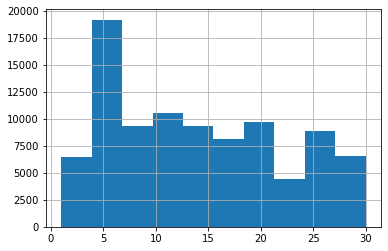

In [33]:
df.days.hist()

In [34]:
df.drop(['ad_date'], axis=1, inplace=True)

### Рассмотрим признаки со множеством пропусков

In [ ]:
candidates_to_drop = ['flat.balcony','flat.balcony_g','map.complex','flat.door','inet.type','live.furniture',
                      'flat.flooring','ceiling','flat.security','has_change','flat.phone','flat.parking']

Попробуем два варианта: 1 - с удалением этих признаков и 2 - попытаемся заполнить пропуски и использовать их

In [ ]:
for col in candidates_to_drop:
    print(col, df[col].nunique(), '\n', df[col].value_counts(dropna=False), '\n')